# Diffusion Model
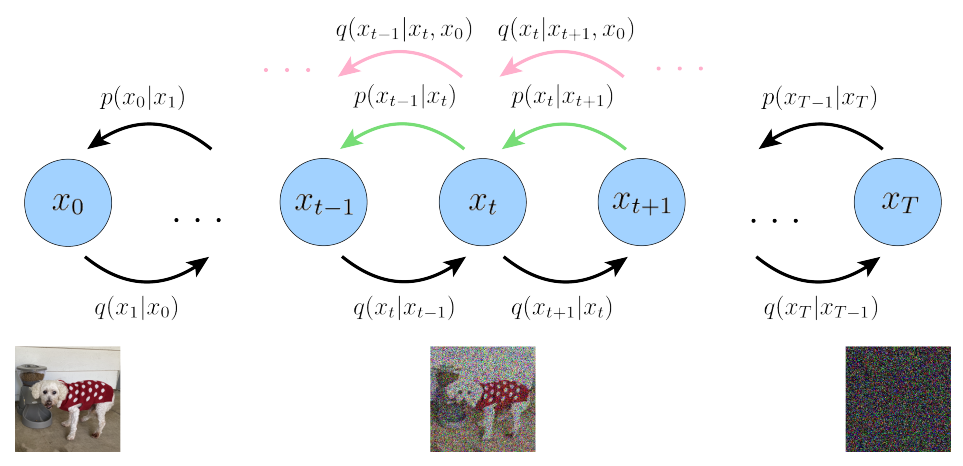

## The Forward Process
### Naive Method

Though we will talk about `Diffusion Models` in detail in the future posts as well, I will implement the forward process here to give you an idea that things that might look complicated in symbols aren't that complicated in terms of code.

Let's rewrite the forward process equation again:

$$
q(x_{1:T}\vert x_{0}) := \prod_{t=1}^{T}q(x_{t}\vert x_{t-1}) :=\prod_{t=1}^{T}\mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t}\bf I)
$$

To implement the above equation:

1. We have to define the total number of timesteps `T`
2. We have to generate $\beta_{t}$ using a schedule. We can use any schedule including but not limited to linear, quadratic, etc. The only thing that we need to ensure is that $\beta_{1} < \beta_{2}...$
3. Sample a new image at timestep `t` from a conditional Gaussian for which the paramters are $\mu_{t} = \sqrt{1-\beta_{t}} x_{t-1}$ and $\sigma_{t}^2 = \beta_{t}$
4. For the last point, we can use the property(eq. (13)) we studied in the conditional distribution section. Hence we can write this as:

$$x_{t} \sim (\mathcal{N}(\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t}) + \mathcal{N}(0, 1))$$

$$
\Rightarrow x_{t} = \sqrt{1-\beta_{t}} x_{t-1} + \sqrt{\beta_{t}}\epsilon \ \ ; \ \text{where} \ \epsilon \sim \mathcal{N}(0, 1) \tag{15}
$$

Now that we have broken down the equation in much simpler parts, let's code it!

(Ref: https://github.com/AakashKumarNain/diffusion_models)

In [15]:
import numpy as np

def forward_process_ddpms(x_t_minus_1, beta, t):
    """Implements the forward process of a DDPM model.
    
    Args:
        x_t_minus_1: x at the previous timestep (t - 1)
        beta: Scheduled Variance
        t: Current timestep
    Returns:
        x_t: x obtained at current timestep t
    """
    
    # 1. Obtain beta_t. Reshape it to have the same number of
    # dimensions as our image array
    beta_t = beta[t].reshape(-1, 1)
    
    # 2. Calculate mean and variance
    mu = np.sqrt((1.0 - beta_t)) * x_t_minus_1
    sigma = np.sqrt(beta_t)
    
    # 3. Obtain image at timestep t using equation (15)
    x_t = mu + sigma * np.random.randn(*x_t_minus_1.shape)
    return x_t

### Simple Example: sin -> Gaussian

(128,)


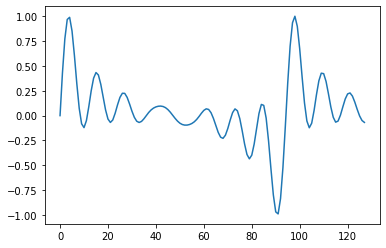

In [2]:
import numpy as np
import matplotlib.pyplot as plt

np.random.seed(0)

def generate_x0(shape):
    weight = np.random.rand(10, 1)
    i = np.arange(shape)/15
    x_0 = 0
    for w in range(weight.shape[0]):    
        x_0 = x_0 + weight[w]*np.sin(w*i)
    return x_0/np.max(x_0)

x_0 = generate_x0(128)
print(x_0.shape)
plt.plot(x_0)
plt.show()

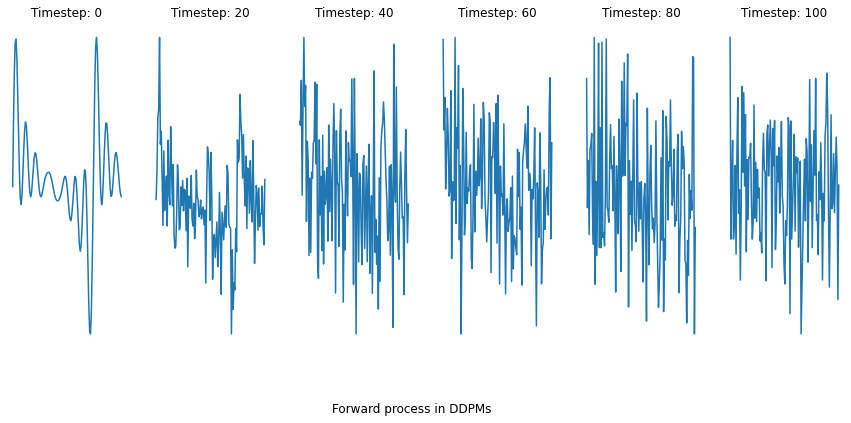

In [3]:
import os

# 1. Set x_0
x_0 = x_0.reshape(1, -1)

# 2. Define number of timesteps
timesteps = 100

# 3. Generate beta (variance schedule)
beta_start = 0.0001
beta_end = 0.05
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)


processed_xs = []
x_t = x_0.copy()

# 4. Run the forward process to obtain img after t timesteps
for t in range(timesteps):
    
    if t%20==0 or t==timesteps - 1:
        sample = x_t.copy()
        processed_xs.append(sample)
    
    x_t = forward_process_ddpms(x_t, beta=beta, t=t)

# 5. Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_xs), figsize=(15, 6))

for i, sample in enumerate(processed_xs):
    ax[i].plot(sample[0])
    ax[i].set_title(f"Timestep: {i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward process in DDPMs", y=0.0)
plt.show()

### Let's See Single Point

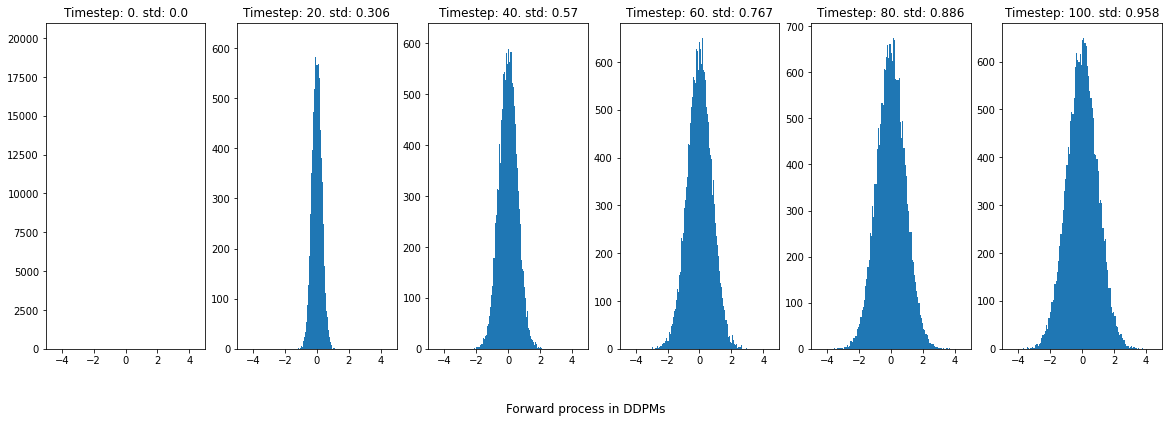

In [4]:
import os

# 1. Set x_0
x_00 = np.array(0).reshape(1, -1)

# 2. Define number of timesteps
timesteps = 100

# 3. Generate beta (variance schedule)
beta_start = 0.0001
beta_end = 0.05
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)

processed_xs = []
exps = 20000
for exp in range(exps):
    x_t = x_00.copy()

    # 4. Run the forward process to obtain img after t timesteps
    for t in range(timesteps):
        if t%20==0 or t==timesteps - 1:
            sample = x_t.copy()
            processed_xs.append(sample)
        x_t = forward_process_ddpms(x_t, beta=beta, t=t)

processed_xs = np.array(processed_xs)
processed_xs = processed_xs[:,0,0]
processed_xs = processed_xs.reshape(exps,6).transpose()


# 5. Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_xs), figsize=(20, 6))

for i, sample in enumerate(processed_xs):
    ax[i].hist(sample, bins=100)
    ax[i].set_title(f"Timestep: {i*20}. std: {np.std(sample):.03}")
    #ax[i].axis("off")
    ax[i].axis(xmin=-5,xmax=5)
    ax[i].grid(False)

plt.suptitle("Forward process in DDPMs", y=0.0)
plt.show()

The variance at time t' is 
$$1-\prod_{t=1}^{t'}(1-\beta_t)$$

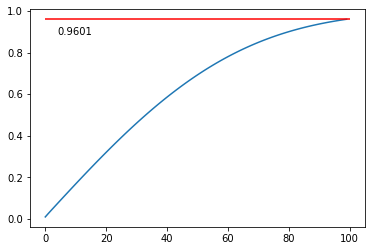

In [5]:
# 3. Generate beta (variance schedule)
beta_start = 0.0001
beta_end = 0.05
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)

# 1. Define alpha and alpha_bar
alpha = 1.0 - beta
alpha_bar = np.cumprod(alpha)
std_ = np.sqrt(1-alpha_bar)

plt.plot(std_)
plt.hlines(y=std_[-1], xmin=0, xmax=len(std_), color='r')
plt.text(4, 0.9, f'{std_[-1]:.4}', ha='left', va='center')
plt.show()

### Reparameterization

Can you spot a major problem with the above equation? (Hint: Check the loop)

Don't worry if you didn't get it. Look at the above code closely. Forget everything from the modelling perspective except for the forward pass. You will notice that to obtain a noisy sample, say at timestep `t`, we need to iterate from `t0` to `t-1`. Why? Because the sample obtained at each timestep is conditioned on the samples from the previous timesteps. 

That's not efficient. What if there are 1000 steps and you want to sample the `999th` timestep? You will iterate the whole loop, simulating the entire Markov Chain. Now that we know the problem, we should think about how we can do better.



We know that sum of the independent Gaussians is still a Gaussian. We can leverage this fact to sample from an arbitrary forward step. All we need to do is apply the `reparameterization` trick.

Let &nbsp; $\alpha_{t} = 1 - \beta_{t},$ &nbsp; and  &nbsp; $\bar{\alpha}_{t} = \prod_{i=1}^T \alpha_{i}$

From equation (1) we know that:


$$
q(x_{1:T}\vert x_{0}) := \prod_{t=1}^{T}q(x_{t}\vert x_{t-1}) :=\prod_{t=1}^{T}\mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t} \bf{I}) \\
$$

$$
\text{or} \ \ q(x_{t}\vert x_{t-1}) = \mathcal{N}(x_{t};\sqrt{1-\beta_{t}} x_{t-1},\ \beta_{t} \bf{I})
$$

We can obtain the sample at timestep `t` as:

$$
x_{t} = \sqrt{1 - \beta_{t}} x_{t-1} +  \sqrt{\beta_{t}}\epsilon_{t-1}; \ \ \text where \ \  \epsilon_{t-1} \sim \mathcal{N}(0, \bf{I})
$$

Replacing $\beta$ with $\alpha$ in the above equation we can obtain sample at timestep `t` as:

$$
\begin{align*}
x_{t} &= \sqrt{\alpha_{t}} x_{t-1} + \sqrt{1 - \alpha_{t}}\epsilon_{t-1} \\
\Rightarrow x_{t} &= 
\sqrt{\alpha_{t}} \ \ \underbrace{(\sqrt{\alpha_{t-1}} x_{t-2} + \sqrt{1 - \alpha_{t-1}}\epsilon_{t-2})}_{\text{( Expanding } x_{t-1})} + 
\sqrt{1 - \alpha_{t}}\epsilon_{t-1} \\ \\
&= \sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + 
\underbrace{\sqrt{\alpha_{t}(1 - \alpha_{t-1})}\epsilon_{t-2}}_{\text{RV1}} + 
\underbrace{\sqrt{1 - \alpha_{t}}\epsilon_{t-1}}_{\text{RV2}} \\
\end{align*}
$$

The two terms namely RV1, and RV2 on RHS in the above equation are two random variables distributed **normally** with a mean of zero and variances $\alpha_{t}(1 - \alpha_{t-1})\ $, and $(1 - \alpha_{t})$ respectively. 

In the last [lesson](https://github.com/AakashKumarNain/diffusion_models/blob/main/notebooks/all_you_need_to_know_about_gaussian.ipynb) we learned that if we have two Gaussian distributions with mean values $\mu_{1} , \mu_{2}$ and variances $\sigma_{1}^2 , \sigma_{2}^2$ respectively, then the sum of these two random variables is equivaluent to another random variable with a normal distribution $\mathcal{N}(\mu_{1} + \mu_{2}, \sigma_{1}^2 +\sigma_{2}^2)$. Applying this to the above equation yields:

$$
\begin{align*}
\Rightarrow x_{t} &= 
\sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + 
\sqrt{\alpha_{t}(1 - \alpha_{t-1}) + 
(1 - \alpha_{t})}\bar{z}_{t-2} & \bar{z}_{t-2} \ \text {is the merged Gaussian} \\
&= \sqrt{\alpha_{t} \alpha_{t-1}} x_{t-2} + 
\sqrt{1 - \alpha_{t} \alpha_{t-1}}\bar{z}_{t-2} \\
&= \ \ ... \\
\Rightarrow x_{t}&= \sqrt{\bar{\alpha_{t}}} x_{0} + 
\sqrt{1 - \bar{\alpha_{t}}}\epsilon \ \  \ \text{ (since } \
\ \bar{\alpha}_{t} = \prod_{i=1}^T \alpha_{i})
\end{align*}
$$

From above, we can say that:

$$
q(x_{t}\vert x_{0}) = \mathcal{N}(x_{t};\sqrt{\bar{\alpha_{t}}} x_{0},\ (1 - \bar{\alpha_{t}}) \ \bf{I}) \tag {2}
$$

Ha! The above equation is nice.Given the original image, we can now sample at any arbitrary timestep without simulating the entire Markov chain till that step. Before coding it up, let's recap of what we did and achieve:

1. We figured out that in the original formulation, we need to simulate the Markov chain to the step for which we want to sample.
2. We reparameterized $\beta$ in terms of $\alpha$
3. The above reparameterization leads to an equation where we can sample at any arbitrary timestep 


Let's code it and compare the results with the previous results 

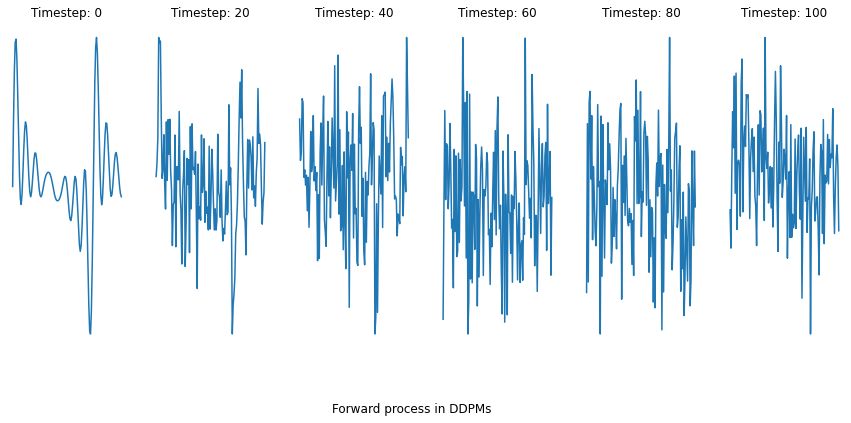

In [6]:
def forward_process_ddpms_v2(x_0, alpha_bar, t):
    """Implements the efficient forward process of a DDPM model.
    
    Args:
        x_0: x at timestep t=0
        alpha_bar: The reparameterized version of beta
        t: Current timestep
    Returns:
        Image obtained at current timestep
    """
    
    # 1. Obtain beta_t. Reshape it to have the same number of
    # dimensions as our image array
    alpha_bar_t = alpha_bar[t].reshape(-1, 1)
    
    # 2. Calculate mean and variance
    mu = np.sqrt(alpha_bar_t) * x_0
    sigma = np.sqrt(1.0 - alpha_bar_t)
    
    # 3. Obtain image at timestep t
    x_t = mu + sigma * np.random.randn(*x_0.shape)
    return x_t

# 3. Generate beta (variance schedule)
beta_start = 0.0001
beta_end = 0.05
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)


# 1. Define alpha and alpha_bar
alpha = 1.0 - beta
alpha_bar = np.cumprod(alpha)

processed_xs = []
x_t = x_0.copy()

# 4. Run the forward process to obtain img after t timesteps
for t in range(timesteps):
    
    if t%20==0 or t==timesteps - 1:
        sample = x_t.copy()
        processed_xs.append(sample)
    
    x_t = forward_process_ddpms_v2(x_0, alpha_bar, t=t)


    
# 5. Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_xs), figsize=(15, 6))

for i, sample in enumerate(processed_xs):
    ax[i].plot(sample[0])
    ax[i].set_title(f"Timestep: {i*20}")
    ax[i].axis("off")
    ax[i].grid(False)

plt.suptitle("Forward process in DDPMs", y=0.0)
plt.show()

### Let's See Single Point

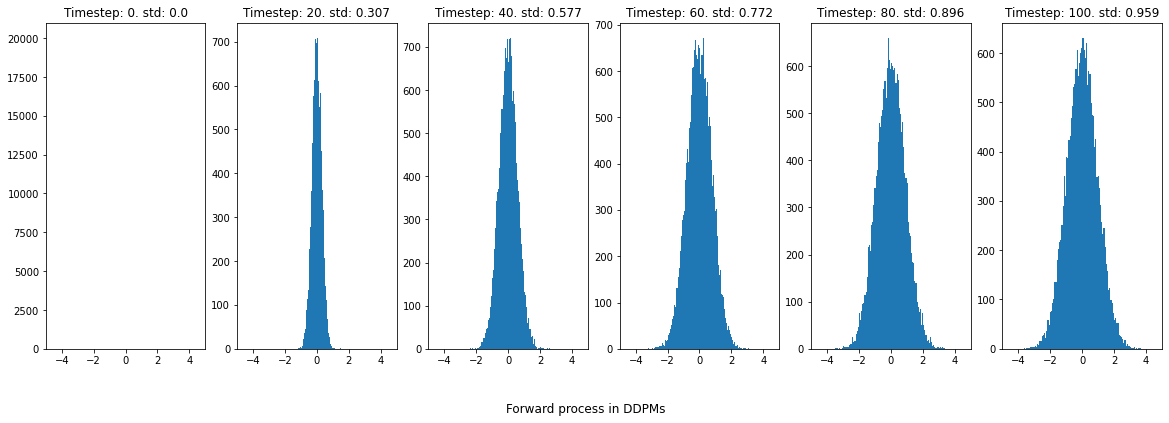

In [18]:
# 1. Set x_0
x_00 = np.array(0).reshape(1, -1)

# 3. Generate beta (variance schedule)
beta_start = 0.0001
beta_end = 0.05
beta = np.linspace(beta_start, beta_end, num=timesteps, dtype=np.float32)


# 1. Define alpha and alpha_bar
alpha = 1.0 - beta
alpha_bar = np.cumprod(alpha)

processed_xs = []
x_t = x_00.copy()

processed_xs = []
exps = 20000
for exp in range(exps):
    x_t = x_00.copy()

    # 4. Run the forward process to obtain img after t timesteps
    for t in range(timesteps):
        
        if t%20==0 or t==timesteps - 1:
            sample = x_t.copy()
            processed_xs.append(sample)
        
        x_t = forward_process_ddpms_v2(x_00, alpha_bar, t=t)

processed_xs = np.array(processed_xs)
processed_xs = processed_xs[:,0,0]
processed_xs = processed_xs.reshape(exps,6).transpose()


# 5. Plot and see samples at different timesteps
_, ax = plt.subplots(1, len(processed_xs), figsize=(20, 6))

for i, sample in enumerate(processed_xs):
    ax[i].hist(sample, bins=100)
    ax[i].set_title(f"Timestep: {i*20}. std: {np.std(sample):.03}")
    #ax[i].axis("off")
    ax[i].axis(xmin=-5,xmax=5)
    ax[i].grid(False)

plt.suptitle("Forward process in DDPMs", y=0.0)
plt.show()

## Reverse Process

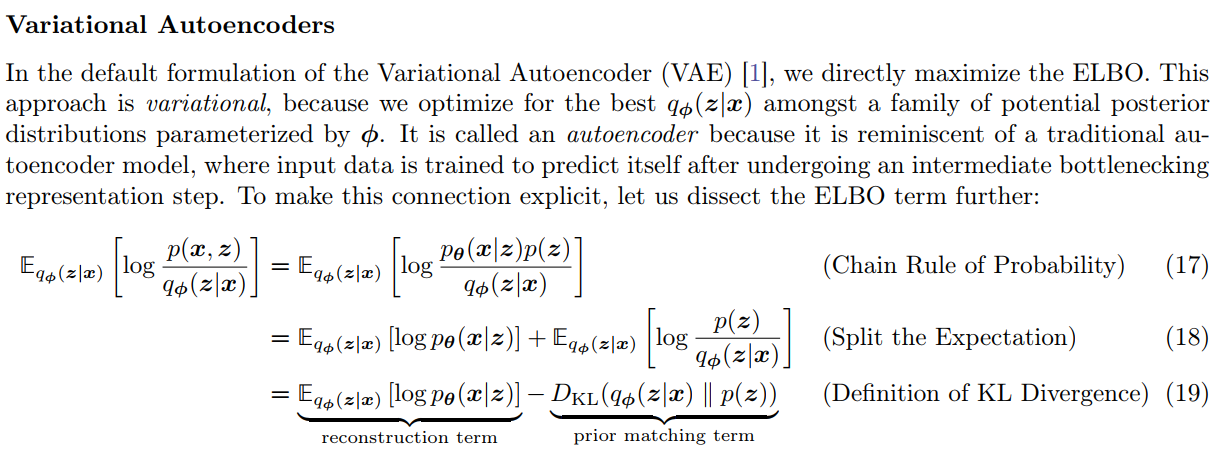
<img src=https://raw.githubusercontent.com/AakashKumarNain/diffusion_models/main/images/vae_ddpm.jpg width="600">
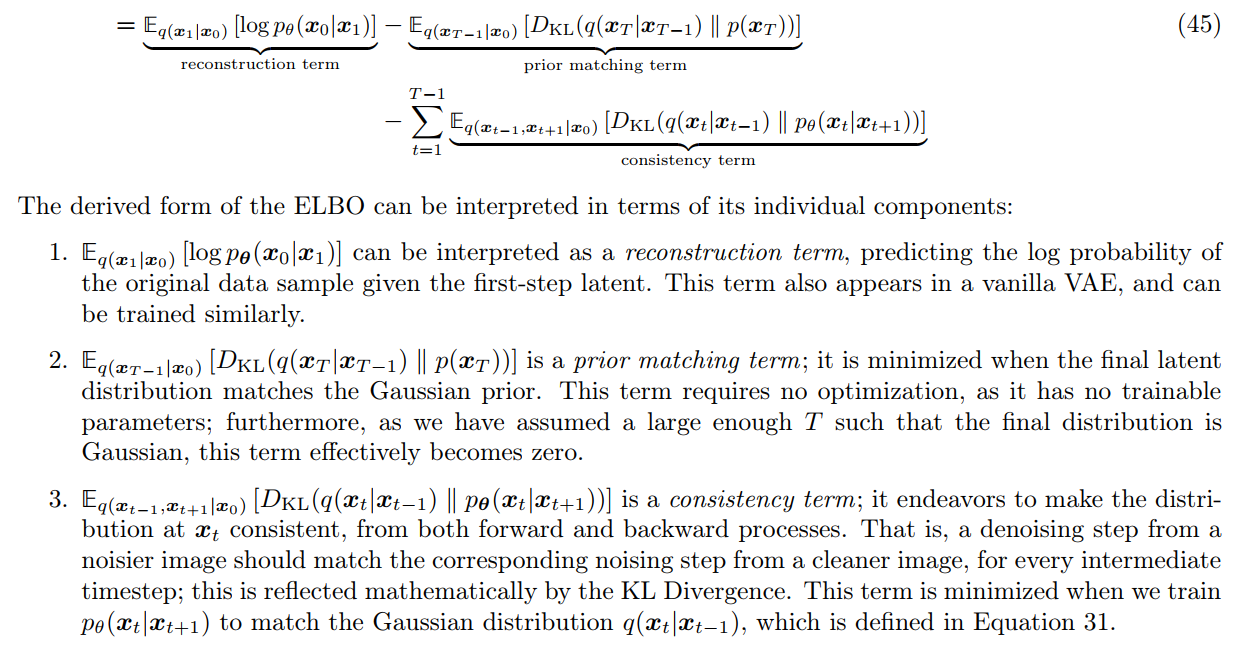
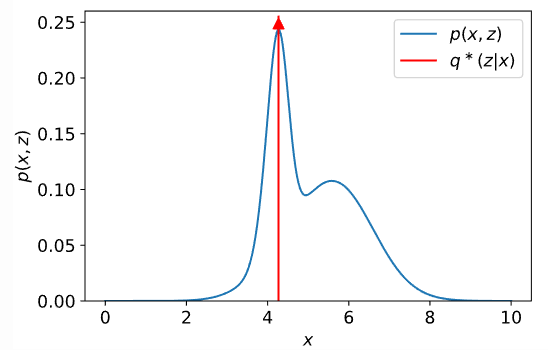

Markov property:
$$ q(x_t|x_{t-1}) = q(x_t|x_{t-1}, x_0) $$
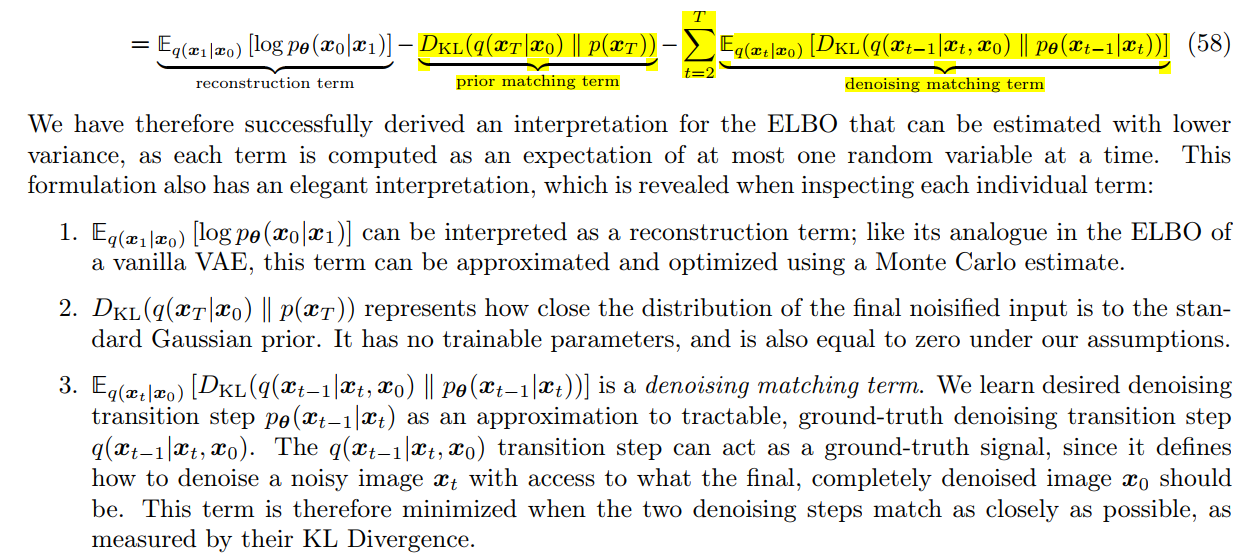
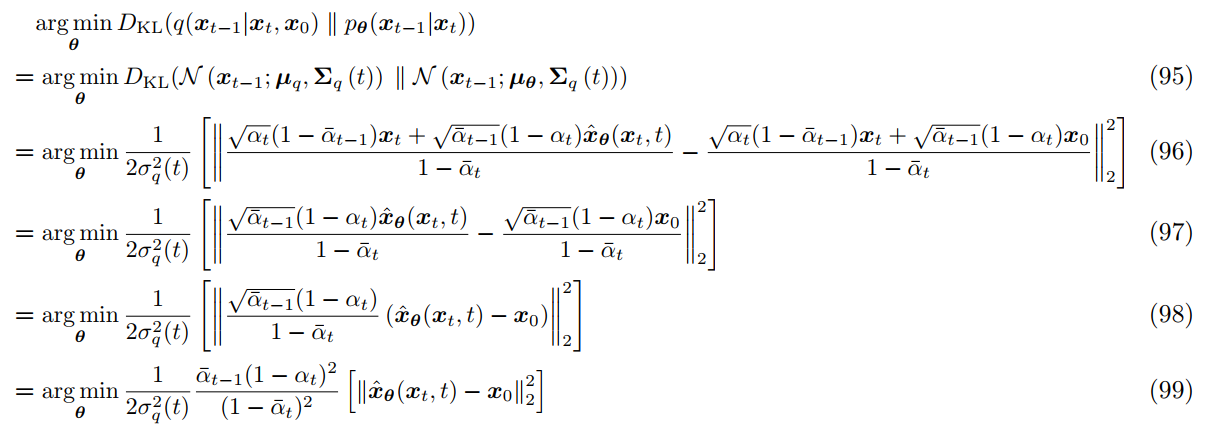
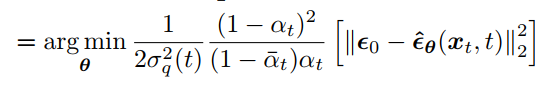

### How to Train
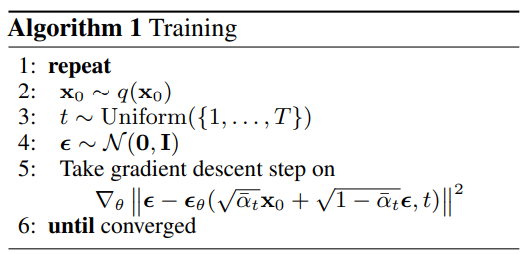

Ref: https://github.com/lucidrains/denoising-diffusion-pytorch
```python
def p_losses(self, x_start, t, *, classes, noise = None):
    b, c, h, w = x_start.shape
    noise = default(noise, lambda: torch.randn_like(x_start))

    # generate noise sample
    x = self.q_sample(x_start = x_start, t = t, noise = noise)

    # predict and take gradient step

    model_out = self.model(x, t, classes)

    if self.objective == 'pred_noise':
        target = noise
    elif self.objective == 'pred_x0':
        target = x_start
    elif self.objective == 'pred_v':
        v = self.predict_v(x_start, t, noise)
        target = v
    else:
        raise ValueError(f'unknown objective {self.objective}')

    loss = self.loss_fn(model_out, target, reduction = 'none')
    loss = reduce(loss, 'b ... -> b (...)', 'mean')

    loss = loss * extract(self.p2_loss_weight, t, loss.shape)
    return loss.mean()
```

## How to Generate
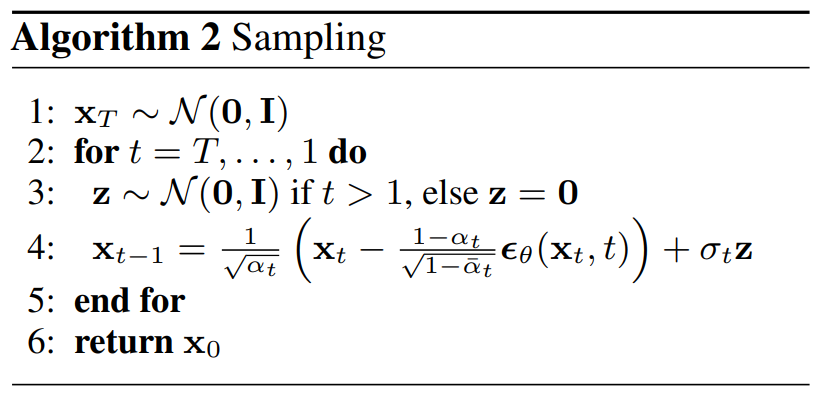

===============================================================================================
$$x_t \rightarrow x_{t-1}$$
```python
@torch.no_grad()
def p_sample_loop(self, shape):
    batch, device = shape[0], self.betas.device

    img = torch.randn(shape, device=device)

    x_start = None

    for t in tqdm(reversed(range(0, self.num_timesteps)), desc = 'sampling loop time step', total = self.num_timesteps):
        self_cond = x_start if self.self_condition else None
        img, x_start = self.p_sample(img, t, self_cond)

    img = self.unnormalize(img)
    return img
```

===============================================================================================
$$p_\theta(x_{t−1}|x_{t}) = N (x_{t−1}; µ_\theta(x_{t}, t), Σ_\theta(x_{t}, t))$$
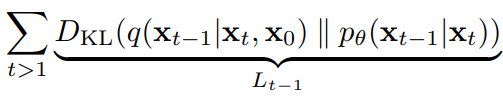

注意，我們的目標是$p_\theta$，而$p_\theta$與$q(\cdot)$"相同"，
但式子$q(\cdot)$裡有$x_0$，$x_0$在inference時不存在，故以model去預測
```python
@torch.no_grad()
def p_sample(self, x, t: int, x_self_cond = None, clip_denoised = True):
    b, *_, device = *x.shape, x.device
    batched_times = torch.full((x.shape[0],), t, device = x.device, dtype = torch.long)
    model_mean, _, model_log_variance, x_start = self.p_mean_variance(x = x, t = batched_times, x_self_cond = x_self_cond, clip_denoised = clip_denoised)
    noise = torch.randn_like(x) if t > 0 else 0. # no noise if t == 0
    pred_img = model_mean + (0.5 * model_log_variance).exp() * noise
    return pred_img, x_start
```
===============================================================================================
$$µ_\theta(x_{t}, t), Σ_\theta(x_{t}, t)$$
```python
def p_mean_variance(self, x, t, x_self_cond = None, clip_denoised = True):
    preds = self.model_predictions(x, t, x_self_cond)
    x_start = preds.pred_x_start

    if clip_denoised:
        x_start.clamp_(-1., 1.)

    model_mean, posterior_variance, posterior_log_variance = self.q_posterior(x_start = x_start, x_t = x, t = t)
    return model_mean, posterior_variance, posterior_log_variance, x_start
```

===============================================================================================
$$q(x_{t-1} | x_t, x_0) $$
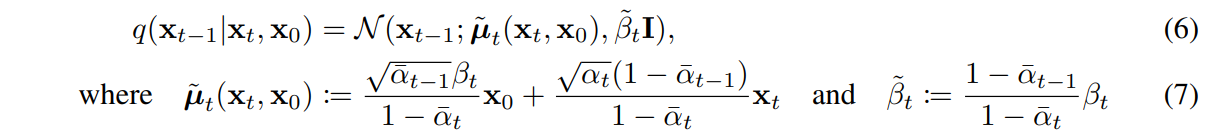
```python
 def q_posterior(self, x_start, x_t, t):
    posterior_mean = (
        extract(self.posterior_mean_coef1, t, x_t.shape) * x_start +
        extract(self.posterior_mean_coef2, t, x_t.shape) * x_t
    )
    posterior_variance = extract(self.posterior_variance, t, x_t.shape)
    posterior_log_variance_clipped = extract(self.posterior_log_variance_clipped, t, x_t.shape)
    return posterior_mean, posterior_variance, posterior_log_variance_clipped
```

## Practice

In [8]:
#!pip install denoising_diffusion_pytorch 
%load_ext autoreload
%autoreload 2

#### Generate x_0 samples

In [9]:
num_x_0 = 1000
x_0_batch = []

for _ in range(num_x_0):
    x_0_batch.append(x_0 + np.random.rand(*x_0.shape)*0.1)

x_0_batch = np.stack(x_0_batch)
x_0_batch = x_0_batch/np.max(x_0_batch)
print(x_0_batch.shape)

(1000, 1, 128)


#### Training

In [ ]:
import torch
from denoising_diffusion_pytorch import Unet1D, GaussianDiffusion1D
import tqdm 

model = Unet1D(
    dim = 64,
    dim_mults = (1, 2, 4, 8),
    channels=1
).to('cuda')

diffusion = GaussianDiffusion1D(
    model,
    seq_length = 128,
    timesteps = 4000,   # number of steps
    loss_type = 'l1'    # L1 or L2
).to('cuda')

x_0_batch_torch = torch.from_numpy(x_0_batch).reshape(num_x_0, 1, 128).type(torch.float).to('cuda')
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-3, betas = (0.9, 0.99))
 

In [11]:
pbar = tqdm.tqdm(range(200))
for epoch in pbar:
    optimizer.zero_grad()
    loss = diffusion(x_0_batch_torch)
    loss.backward()
    # after a lot of training
    pbar.set_postfix({'Loss': loss.item()})
    optimizer.step()


100%|██████████| 200/200 [02:01<00:00,  1.64it/s, Loss=0.295]


In [12]:
sampled_images = diffusion.sample(batch_size = 4)

sampling loop time step: 100%|██████████| 4000/4000 [01:49<00:00, 36.53it/s]


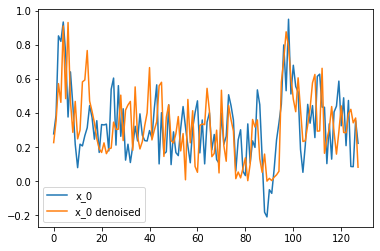

In [14]:
plt.plot(x_0_batch[0,0,:])
plt.plot(sampled_images[0,0,:].detach().cpu().numpy())
plt.legend(['x_0','x_0 denoised'])